# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [2]:
# These libraries may be useful to you

#!pip3 install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

#!python3 -m spacy download en_core_web_sm

nlp = spacy.load('en_core_web_sm')

In [3]:
# add any additional libaries you need here
np.int = np.int_
np.float = np.float_
import re
import os
import nltk
import zipfile
import shutil
import html
import matplotlib
import matplotlib.pyplot as plt

#first, download the stopwords.zip file from https://www.nltk.org/nltk_data/ and then extract it
stop_source_dir = '/Users/calebmccurdy/downloads/stopwords'
stop_dest_dir = '/Users/calebmccurdy/nltk_data/corpora/stopwords'

if os.path.exists(stop_dest_dir):
    shutil.rmtree(stop_dest_dir)
shutil.move(stop_source_dir, stop_dest_dir)

#first, download the punkt.zip file from https://www.nltk.org/nltk_data/ and then extract it
punkt_source_dir = '/Users/calebmccurdy/downloads/punkt'
punkt_dest_dir = '/Users/calebmccurdy/nltk_data/corpora/punkt'

if os.path.exists(punkt_dest_dir):
    shutil.rmtree(punkt_dest_dir)
shutil.move(punkt_source_dir, punkt_dest_dir)

#first, download the punkt.zip file from https://www.nltk.org/nltk_data/ and then extract it
brown_source_dir = '/Users/calebmccurdy/downloads/brown'
brown_dest_dir = '/Users/calebmccurdy/nltk_data/corpora/brown'

if os.path.exists(brown_dest_dir):
    shutil.rmtree(brown_dest_dir)
shutil.move(brown_source_dir, brown_dest_dir)

'/Users/calebmccurdy/nltk_data/corpora/brown'

In [8]:
from nltk.corpus import brown
from nltk.corpus import stopwords
sw = stopwords.words("english")

In [9]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [10]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [11]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [12]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

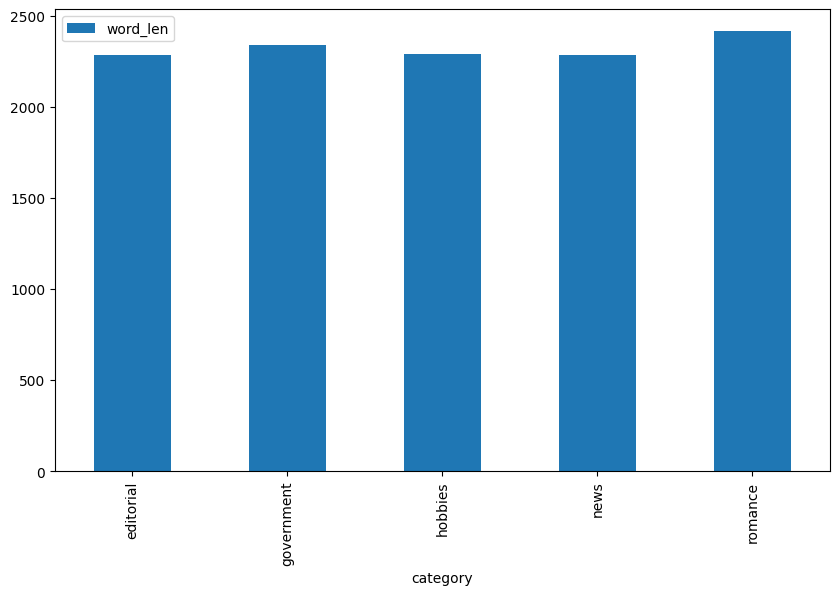

In [13]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [17]:
count_text_vectorizer = CountVectorizer(stop_words=list(sw), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 5073)

In [19]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(sw), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 5073)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The rows of each `count_text_vectors` and `tfidf_text_vectors` hold the articles from the previously decided 5 categories of the brown corpus. The columns are the unique words in these articles as long as they appear in a minimum of 5 and a maximum of 70% of them. In these ways, they are the same in terms of their structures, however, the values are different. For `count_text_vectors`, the values are the count of the unique word within each document. For `tfidf_text_vectors`, the values are the TF-IDF scores: the importance of the word to the document relative to the whole corpus. 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [20]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [38]:
# assertion statements to ensure the document-topic and topic-feature matrices have the intended shapes
assert W_text_matrix.shape == (166, 5), f"Expected shape (166, 5), but got {W_text_matrix.shape}"
assert H_text_matrix.shape == (5, 5073), f"Expected shape (5, 5073), but got {H_text_matrix.shape}"

In [21]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.48)
  president (0.43)
  kennedy (0.41)
  united (0.40)
  khrushchev (0.38)

Topic 01
  said (0.78)
  thought (0.38)
  back (0.34)
  man (0.34)
  little (0.31)

Topic 02
  mrs (2.38)
  mr (0.75)
  said (0.71)
  miss (0.48)
  car (0.46)

Topic 03
  state (0.38)
  development (0.35)
  tax (0.32)
  sales (0.29)
  may (0.28)

Topic 04
  game (0.97)
  league (0.70)
  ball (0.69)
  baseball (0.66)
  team (0.63)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [42]:
# Add NMF topic assignments to the DataFrame using the maximum topic weight for each article in the document-topic matrix
# https://www.geeksforgeeks.org/numpy-argmax-python/ 
df['nmf_topic'] = np.argmax(W_text_matrix, axis=1)

# Compare NMF topics vs. original categories
cross_tab_nmf_original = pd.crosstab(df['nmf_topic'], df['category'])
print(cross_tab_nmf_original)

category   editorial  government  hobbies  news  romance
nmf_topic                                               
0                 21           5        1     8        0
1                  5           0       10     0       29
2                  0           0        1    18        0
3                  1          25       22     9        0
4                  0           0        2     9        0


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The five-topic NMF model agrees a decent amount with the Brown corpus categories, with some topics being more closely associated with a specific category than others. Out of the 27 editorial articles, 21 (77.8%) of them were placed in our model's Topic 00. For the government articles, 25 of the 30 (83.3%) were placed in the same topic 03. All of the romance articles were assigned to the same Topic 01. For news, the assignments were more spread out, although there was a clear topic that stood out still with 18 out of 44 (40.9%) being in Topic 02. The hobbies articles had two main topics they were categorized into which were Topic 01 (27.8%) and Topic 03 (61.1%). These topics seem overall well-defined and do a good job at grouping articles that should be related together. However, in a case like Topic 03, it might get the majority of articles from multiple true categories which can make it hard to categorize from the model. 

Topic 00: mainly editorial articles woith some news articles

Topic 01: mainly romance articles with some hobbies and editorial articles

Topic 02: strong association with news articles

Topic 03: mix of government and hobbies articles with some news as well

Topic 04: mainly news articles with a couple hobbies articles

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [40]:
svd_text_model = TruncatedSVD(n_components=5, random_state=315)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

In [41]:
assert W_svd_text_matrix.shape == (166, 5), f"Expected shape (166, 5), but got {W_svd_text_matrix.shape}"
assert H_svd_text_matrix.shape == (5, 5073), f"Expected shape (5, 5073), but got {H_svd_text_matrix.shape}"

In [45]:
# Add LSA topic assignments to the DataFrame using the maximum topic weight for each article in the document-topic matrix
# https://www.geeksforgeeks.org/numpy-argmax-python/ 
df['lsa_topic'] = np.argmax(np.abs(W_svd_text_matrix), axis=1)

# Compare LSA topics vs. original categories
cross_tab_lsa_original = pd.crosstab(df['lsa_topic'], df['category'])
print(cross_tab_lsa_original)

category   editorial  government  hobbies  news  romance
lsa_topic                                               
0                 27          19       30    33       25
1                  0          10        0     0        4
2                  0           1        6     3        0
3                  0           0        0     1        0
4                  0           0        0     7        0


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The five-topic LSA model does not do nearly as good of a job at separating the texts into categories as it assigns the vast majority within each true category all to Topic 00. This highly assigned topic appears to be very general while some of the others do not have many articles but are more well defined. Topic 01 is mostly related to government and romance while Topic 02 is focused on government, hobbies, and news. Topic 04 has strong relevance to news. Topic 03 only has one article assignment which suggests it may be a subtopic of hobbies. 

In [47]:
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.41)
  mr (0.23)
  mrs (0.20)
  state (0.19)
  man (0.16)

Topic 01
  said (3.71)
  thought (2.13)
  back (1.91)
  got (1.90)
  looked (1.76)

Topic 02
  mrs (4.60)
  mr (1.95)
  said (1.49)
  jr (0.89)
  jury (0.84)

Topic 03
  khrushchev (3.00)
  berlin (2.35)
  soviet (2.22)
  kennedy (2.16)
  laos (2.00)

Topic 04
  game (5.38)
  league (3.82)
  baseball (3.79)
  ball (3.69)
  team (3.41)


Q: What is your interpretation of the display topics output? 

A: Based on the low values of the words in Topic 00, they do not have great contribution to making a clearly defined topic which makes sense as its articles are spead out amongst the categories when applying the model. The individual contributions of "said" and "thought" are high for Topic 01 which houses government and romance articles. This makes sense as those words often appear in these writing styles. Topic 02 has a fairly steep drop-off which suggests a strongly defined category, although the words with high contributions do not tell us much. The largely contributing words in Topic 03 suggest a well-defined Cold War topic. Topic 04 has clear association to sports as it only refers to games and baseball related words. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [52]:
lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [53]:
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  may (0.89)
  state (0.87)
  states (0.73)
  use (0.57)
  united (0.54)

Topic 01
  mrs (1.37)
  feed (0.70)
  per (0.49)
  house (0.44)
  pool (0.41)

Topic 02
  mr (0.60)
  president (0.51)
  american (0.44)
  world (0.42)
  united (0.40)

Topic 03
  said (1.31)
  state (0.60)
  000 (0.54)
  business (0.54)
  sales (0.44)

Topic 04
  said (1.24)
  back (0.60)
  old (0.50)
  little (0.49)
  man (0.45)


In [59]:
assert W_lda_text_matrix.shape == (166, 5), f"Expected shape (166, 5), but got {W_lda_text_matrix.shape}"
assert H_lda_text_matrix.shape == (5, 5073), f"Expected shape (5, 5073), but got {H_lda_text_matrix.shape}"

In [54]:
df['lda_topic'] = np.argmax(W_lda_text_matrix, axis=1)

# Compare LDA topics vs. original categories
cross_tab_lda_original = pd.crosstab(df['lda_topic'], df['category'])
print(cross_tab_lda_original)

category   editorial  government  hobbies  news  romance
lda_topic                                               
0                  0          15       11     0        0
1                  1           1       10     5        0
2                 22           9        8    14        0
3                  0           5        2    17        0
4                  4           0        5     8       29


Q: What inference do you draw from the displayed topics for your LDA model? 

A: As compared to NMF, this LDA model does not appeart to have as clear or strong of main topics. This is likely due to the process of Latent Dirichlet Allocations focusing on different topics within documents. Topic 00 seems to be United States speeches related. Topic 01 is not clear although it may be discussing family life. Topic 02 is about world relations as it pertains to the United States. Topic 03 is not well defined although it may be about dialogue. Topic 04 also does not appear to be well defined. 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: As we expected with many of the topics not being well defined, they each have a good amount of articles from several true categories. Topic 00 has the majority of its texts as government articles which confirms our suggestion that it might be about United States speeches. Topic 01 is mainly hobbies related which is pretty simialr to pur family life suggestion. Topic 02 is very spread out which was not expected as it seemed very United States world relations focused. Topic 03 is mostly news articles which alligns with our dialogue interpretation. Lastly, Topic 04 is mainly romance articles although it has a good number from editorial, hobbies, and news articles. 

In [57]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [58]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: As we can see from the size of the bubbles in the pca scatterplot, Topic 3 (which is previously described as 'Topic 02') is the largest topic while Topic 2 (which is previously described as 'Topic 01') is the smallest. 

Topic 1: In the salient terms graphs, we see that this topic has a decent inital decline in the length of the bars which means there is some pronouncing of this topic. Additionally, there is no overlap between its PCA bubble and any of the other topic bubbles, although it is fairly close to Topic 4 (both have subtopics that are somewhat related to domestic policies such as taxes).

Topic 2: In the salient terms graphs, we see that this topic is pretty steady in the length of the bars which means there it is not well pronounced. Additionally, it is far away from the other bubbles in the PCA scatterplot so it is unlike the others.

Topic 3: In the salient terms graphs, we see that the terms in this topic are very government-focused and it is pronounced. From the size of the bubble, we know that a lot of the texts in this corpus will be focused on these topic with over 30% of all tokens being related to this topic the most. There is slight overlap with Topic 4 which makes sense as some of its top terms also are government-related: "tax", "president", "federal". 

Topic 4: In the salient terms graphs, we see that this topic is not very well pronounced and has sevral subtopics within it. "Dialogue", "governemt", and "prices" all seem to make up this topic which does not experience much decline in the length of the bars. 

Topic 5: In the salient terms graphs, we see that aside from the initial couple of terms, there is a very slight decline in bar length which suggests the topic is not well defined. Most of the terms in the top-30 list are not good categorizers as they are more broad and can apply to various situation types. It is hard to suggest may topics from this graph. It is also important to note that its terms do not seem to align with the terms from the other topics which can be shown through the distance separation in the PCA scatterplot.